In [1]:
#@title Import libs

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from IPython import display
from tqdm.notebook import tqdm
from matplotlib.pyplot import imread
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {}
#kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [2]:
#@title Useful plot function

def plot_predicted_images(selected_idx, images, pred, labels, uncertainties, hists, mc_samples):
    """ Plot predicted images along with mean-pred probabilities histogram, maxprob frequencies and some class histograms
    across sampling
    
    Args:
      selected_ix: (array) chosen index in the uncertainties tensor
      images: (tensor) images from the test set
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
      
    Returns:
        None
    """
    plt.figure(figsize=(15,10))

    for i, idx in enumerate(selected_idx):   
        # Plot original image
        plt.subplot(5,6,1+6*i)
        plt.axis('off')
        plt.title(f'var-ratio={uncertainties[idx]:.3f}, \n gt={labels[idx]}, pred={pred[idx]}')
        plt.imshow(images[idx], cmap='gray')

        # Plot mean probabilities
        plt.subplot(5,6,1+6*i+1)
        plt.title('Mean probs')
        plt.bar(range(10), mc_samples[idx].mean(0))
        plt.xticks(range(10))

        # Plot frequencies
        plt.subplot(5,6,1+6*i+2)
        plt.title('Maxprob frequencies')
        plt.bar(range(10), hists[idx])
        plt.xticks(range(10))

        # Plot probs frequency for specific class
        list_plotprobs = [hists[idx].argsort()[-1], hists[idx].argsort()[-2], hists[idx].argsort()[-4]]
        ymax = max([max(np.histogram(mc_samples[idx][:,c])[0]) for c in list_plotprobs])
        for j, c in enumerate(list_plotprobs):
            plt.subplot(5,6,1+6*i+(3+j))
            plt.title(f'Samples probs of class {c}')
            plt.hist(mc_samples[idx][:,c].numpy(), bins=np.arange(0,1.1,0.1))
            plt.ylim(0,np.ceil(ymax/10)*10)
            plt.xticks(np.arange(0,1,0.1), rotation=60)

    plt.tight_layout()
    plt.show()

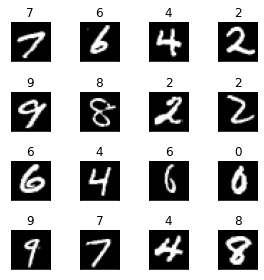

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=128, **kwargs)

# Visualize some images
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{label}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

In [4]:
#@title **[CODING TASK]** Implement a LeNet5-style neural network

class LeNet5(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, (5, 5), stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(6, 16, (5, 5), stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d((2, 2), stride=2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, n_classes)
        
    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Be careful, the dropout layer should be also 
        # activated during test time.
        #(Hint: we may want to look out at F.dropout())
        bsize, channels, w, h = x.size()
        x = self.conv1(x)
        x = F.relu(self.maxpool1(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool2(x))
        x = F.dropout2d(x, p=0.25, training=self.training)
        x = F.relu(self.fc1(x.view(bsize, -1)))
        x = F.dropout2d(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return x

In [5]:
lenet = LeNet5(n_classes=len(train_dataset.classes)).to(device)
lenet.train()
optimizer = torch.optim.SGD(lenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

for i in range(20):
    total_loss, correct = 0.0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = lenet(images)
        loss = criterion(output, labels)
        total_loss += loss
        correct += (output.argmax(-1) == labels).sum()
        loss.backward()
        optimizer.step()
    print(f"[Epoch {i + 1:2d}] loss: {total_loss/ len(train_dataset):.2E} accuracy_train: {correct / len(train_dataset):.2%}")
torch.save(lenet.state_dict(), 'lenet_final.cpkt')

[Epoch  1] loss: 3.78E-03 accuracy_train: 84.42%
[Epoch  2] loss: 1.22E-03 accuracy_train: 95.34%
[Epoch  3] loss: 9.54E-04 accuracy_train: 96.38%
[Epoch  4] loss: 7.91E-04 accuracy_train: 96.94%
[Epoch  5] loss: 7.09E-04 accuracy_train: 97.37%
[Epoch  6] loss: 6.62E-04 accuracy_train: 97.51%
[Epoch  7] loss: 6.24E-04 accuracy_train: 97.63%
[Epoch  8] loss: 5.83E-04 accuracy_train: 97.76%
[Epoch  9] loss: 5.41E-04 accuracy_train: 97.88%
[Epoch 10] loss: 5.16E-04 accuracy_train: 97.98%
[Epoch 11] loss: 4.90E-04 accuracy_train: 98.05%
[Epoch 12] loss: 4.80E-04 accuracy_train: 98.12%
[Epoch 13] loss: 4.47E-04 accuracy_train: 98.26%
[Epoch 14] loss: 4.23E-04 accuracy_train: 98.32%
[Epoch 15] loss: 4.06E-04 accuracy_train: 98.37%
[Epoch 16] loss: 4.07E-04 accuracy_train: 98.39%
[Epoch 17] loss: 3.96E-04 accuracy_train: 98.40%
[Epoch 18] loss: 4.02E-04 accuracy_train: 98.43%
[Epoch 19] loss: 3.80E-04 accuracy_train: 98.50%
[Epoch 20] loss: 3.63E-04 accuracy_train: 98.60%


In [6]:
#@title **[CODING TASK]** Implement variational-ratio, entropy and mutual information

def predict_test_set(model, test_loader, mode='mcp', s=100, temp=5, epsilon=0.0006, verbose=True):
    """Predict on a test set given a model 
    # and a chosen method to compute uncertainty estimate
    # (mcp, MC-dropout with var-ratios/entropy/mutual information 
    # ConfidNet and ODIN)

    Args:
      model: (nn.Module) a trained model
      test_loader: (torch.DataLoader) a Pytorch dataloader based on a dataset
      mode: (str) chosen uncertainty estimate method (mcp, var-ratios, entropy, mi, odin)
      s: (int) number of samples in MCDropout
      temp: (int, optional) value of T for temperature scaling in ODIN
      epsilon: (float, optional) value of epsilon for inverse adversarial perturbation in ODIN
      verbose: (bool, optional) printing progress bar when predicting   
      
    Returns:
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
    """

    model.eval()
    preds, uncertainties, labels, errors  = [], [], [], []
    mc_samples, hists = [], []
    
    loop = tqdm(test_loader, disable=not verbose)
    for images, targets in loop:
        images, targets = images.to(device), targets.to(device)
        
        if mode in ['mcp','odin']:
            model.training = False           
            if mode=='odin':
                # Coding task in Section 3: implement ODIN
                images = odin_preprocessing(model,images,epsilon).to(device)
            with torch.no_grad():
                output = model(images)
            if isinstance(output,tuple):
                output = output[0]
            if mode =='odin':
                output = output / temp
            confidence, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            confidence = confidence.detach().to('cpu').numpy()
            
        elif mode in ['var-ratios', 'entropy', 'mut_inf']:
            model.training = True
            outputs = torch.zeros(images.shape[0], s, 10)
            for i in range(s):
                with torch.no_grad():
                    outputs[:,i] = model(images)
            mc_probs = F.softmax(outputs, dim=2)
            predicted_class = mc_probs.max(dim=2)[1]
            pred = mc_probs.mean(1).max(dim=1, keepdim=True)[1]
            mc_samples.extend(mc_probs)
            hist = np.array([np.histogram(predicted_class[i,:], range=(0,10))[0]  
                              for i in range(predicted_class.shape[0])])
            hists.extend(hist)

            # ============ YOUR CODE HERE ============
            if mode=='var-ratios':
                # You may want to use the hist variable here
                confidence = torch.from_numpy(1-hist.max(1)/s)
            elif mode=='entropy':
                confidence = - (mc_probs.mean(1) * torch.log(mc_probs.mean(1))).sum(1)
            elif mode=='mut_inf':
                H = - (mc_probs.mean(1) * torch.log(mc_probs.mean(1))).sum(1)
                confidence = H + (mc_probs * torch.log(mc_probs)).nansum((1,2)) / s
                
            # ======================================= 
        
        elif mode=='confidnet':
            with torch.no_grad():
                output, confidence = model(images)
            _, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            confidence = confidence.detach().to('cpu').numpy()
        else:
            raise(NotImplementedError("Implemented mode are :'var-ratios', 'entropy', 'mut_inf', 'confidnet'"))

        preds.extend(pred)
        labels.extend(targets)
        uncertainties.extend(confidence)
        errors.extend((pred.to(device)!=targets.view_as(pred)).detach().to("cpu").numpy())

    preds = np.reshape(preds, newshape=(len(preds), -1)).flatten()
    labels = np.reshape(labels, newshape=(len(labels), -1)).flatten()
    uncertainties = np.reshape(uncertainties, newshape=(len(uncertainties), -1)).flatten()
    errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()

    if mode in ['var-ratios', 'entropy', 'mi']:
        hists = np.reshape(hists, newshape=(len(hists), -1))

    print(f'Test set accuracy = {(preds == labels).sum()/len(preds):.2%}')
    
    return preds, labels, uncertainties, errors, hists, mc_samples

In [7]:
# Predicting along with var-ratios uncertainty estimates
pred_var, labels, uncertainty_var, errors_var, \
    hists, mc_samples = predict_test_set(lenet, test_loader, mode='var-ratios')

  0%|          | 0/79 [00:00<?, ?it/s]

Test set accuracy = 99.04%


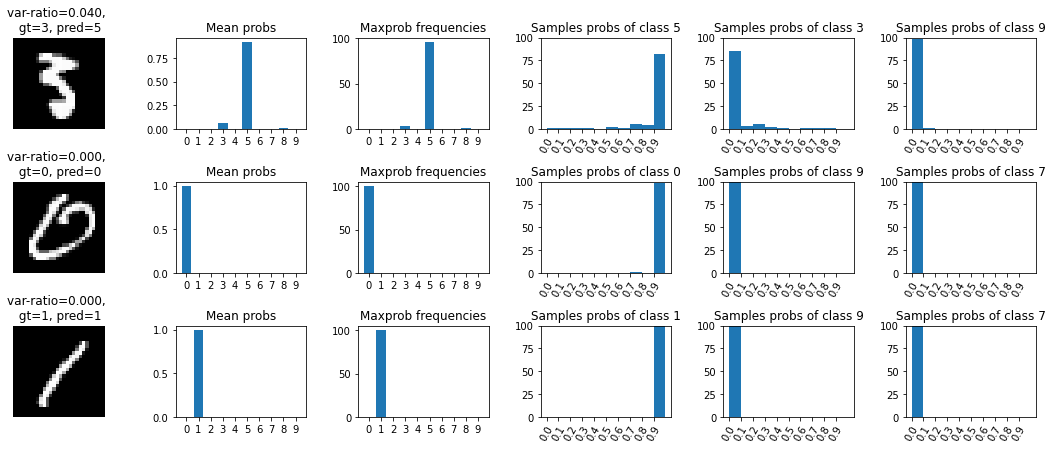

In [8]:
# Plotting random images with their var-ratios value
random_samples = np.random.choice(uncertainty_var.shape[0], 3, replace=False)
plot_predicted_images(random_samples, test_loader.dataset.data, pred_var, labels, uncertainty_var, hists, mc_samples)

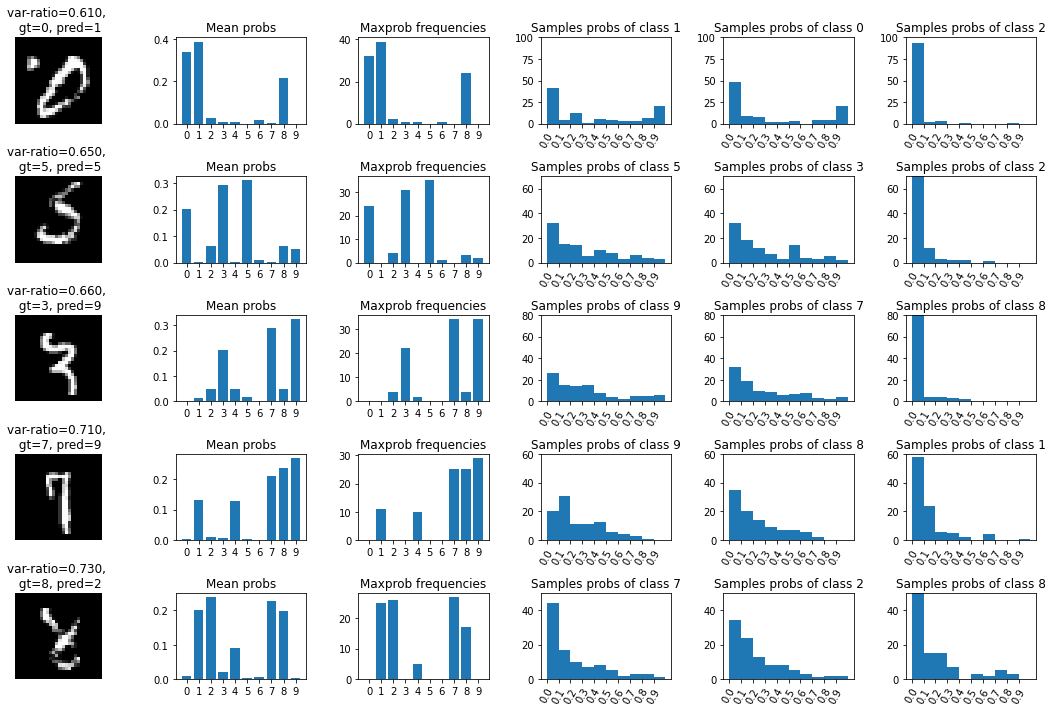

In [9]:
#@title **[CODING TASK]** Visualize the top-3 most uncertain images along with their var-ratios value 

# ============ YOUR CODE HERE ============
# Re-use the function 'plot_predicted_images' to visualize 
# results.

plot_predicted_images(uncertainty_var.argsort()[-5:], test_loader.dataset.data, pred_var, labels, uncertainty_var, hists, mc_samples)